In [1]:
import numpy as np
import os
import argparse
from skimage.io import imsave
import nibabel as nb
import pandas as pd
import matplotlib
matplotlib.rcParams['font.size']=16



import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

In [2]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm1d, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
from nilearn import plotting

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

#### Importing Images

In [4]:
imageArray=np.full((31988-31768,197,233,189),0)
maskArray=np.full((31988-31768,197,233,189),0)


# concatenate all the files into a single tensor
for i in range(31768,31988):
    idx=i
    filename='ATLAS_R1.1 - Copy/0'+str(idx)+'_t1w_deface_stx.nii.gz'
    img=nb.load(filename)
    imageArray[i-31768,:,:,:]=img.get_fdata()


#### Importing Mask

In [5]:
for i in range(31768,31988):
    mask_name='ATLAS_R1.1 - Copy/0'+str(i)+'_LesionSmooth_stx.nii.gz'
    mask=nb.load(mask_name)
    maskArray[i-31768,:,:,:]=mask.get_fdata()

#### Extracting Image and Masks

In [ ]:
lesions= maskArray[:,:,:,:].nonzero()

In [ ]:
print(len(lesions[0]),len(lesions[1]),len(lesions[2]),len(lesions[3]))

In [ ]:
image_count=imageArray . shape[0]
count_top=imageArray.shape[3]
count_front=imageArray.shape[2]
count_side=imageArray.shape[1]

total_pixels=imageArray.shape[1]*imageArray.shape[2]*imageArray.shape[3]
lesion_pixels=np.zeros((image_count,6))

lesion_area_top=np.zeros((image_count,count_top,7))
lesion_area_front=np.zeros((image_count,count_front,7))
lesion_area_side=np.zeros((image_count,count_side,7))

In [ ]:
total_pixels

#### Lesion Area

In [ ]:
# Calculating Area
for i in range(image_count):
    for j in range(count_top):
        mask = maskArray [i,:,:,j] .nonzero()
        lesion_pix=len(mask[0])
        lesion_area_top[i,j,0]= i
        lesion_area_top[i,j,1]= lesion_pix
        lesion_area_top[i,j,2]= 100* lesion_pix/(count_front*count_side) 
        lesion_area_top[i,j,3]= 1
        lesion_area_top[i,j,4]= j
        if lesion_pix != 0 :
            lesion_area_top[i,j,5]= np.mean(mask[0])
            lesion_area_top[i,j,6]= np.mean(mask[1])
        
        
        
    for k in range(count_front):
        mask = maskArray [i,:,k,:] .nonzero()
        lesion_pix=len(mask[0])
        lesion_area_front[i,k,0]= i
        lesion_area_front[i,k,1]= lesion_pix
        lesion_area_front[i,k,2]= 100* lesion_pix/(count_top*count_side)
        lesion_area_front[i,k,3]= 2
        lesion_area_front[i,k,4]= k
        if lesion_pix != 0 :
            lesion_area_front[i,k,5]= np.mean(mask[0])
            lesion_area_front[i,k,6]= np.mean(mask[1])
                
        
    for l in range(count_side):
        mask = maskArray [i,l,:,:] .nonzero()
        lesion_pix=len(mask[0])
        lesion_area_side[i,l,0]= i
        lesion_area_side[i,l,1]= lesion_pix
        lesion_area_side[i,l,2]= 100* lesion_pix/(count_top*count_front)
        lesion_area_side[i,l,3]= 3
        lesion_area_side[i,l,4]= l
        if lesion_pix != 0 :
            lesion_area_side[i,l,5]= np.mean(mask[0])
            lesion_area_side[i,l,6]= np.mean(mask[1])
        

In [ ]:
lesion_area_top.shape

In [ ]:
lesion_area_top_table=pd.DataFrame(lesion_area_top.reshape\
                                   (image_count*count_top,7),\
                                   columns=["Scan #","Lesion Area(pixels)",\
                                            "Lesion Area(%)",\
                                            "View[top=1, front=2, side=3]",\
                                           "Slice #","Centroid x","Centroid y"])
lesion_area_front_table=pd.DataFrame(lesion_area_front.reshape\
                                   (image_count*count_front,7),\
                                   columns=["Scan #","Lesion Area(pixels)",\
                                            "Lesion Area(%)",\
                                            "View[top=1, front=2, side=3]",\
                                           "Slice #","Centroid x","Centroid y"])
lesion_area_side_table=pd.DataFrame(lesion_area_side.reshape\
                                   (image_count*count_side,7),\
                                   columns=["Scan #","Lesion Area(pixels)",\
                                            "Lesion Area(%)",\
                                            "View[top=1, front=2, side=3]",\
                                           "Slice #","Centroid x","Centroid y"])

In [ ]:
lesion_area=lesion_area_top_table.append(lesion_area_front_table\
                                         .append(lesion_area_side_table))

In [ ]:
lesion_area_top_table.shape

In [ ]:
top= lesion_area_top_table.loc[lesion_area_top_table.iloc[:,2]>0]
front= lesion_area_front_table.loc[lesion_area_front_table.iloc[:,2]>0]
side=lesion_area_side_table.loc[lesion_area_side_table.iloc[:,2]>0]

In [ ]:
top.shape

In [ ]:


n_bins=20

fig, axs= plt.subplots(1,3,sharey=True, tight_layout=True, figsize=(12,5))

axs[0].hist(top.iloc[:,2],bins=20)
axs[0].set_xlabel('Top(%)')
axs[0].set_ylabel('Frequency')
axs[1].hist(front.iloc[:,2],bins=20)
axs[1].set_xlabel('Front(%)')
axs[2].hist(side.iloc[:,2],bins=20)
axs[2].set_xlabel('Side(%)')

plt.suptitle('Percentage Lesion Area by View for slices with Lesions',y=1.02)

plt.show()

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d',)

matplotlib.rcParams['font.size']=10
x=top.iloc[:,5]
y=top.iloc[:,6]


X,Y=np.meshgrid(x,y)
Z=0
hist, xedges, yedges=np.histogram2d(x,y,bins=20, range=[[20,x.max()],[20,y.max()]])


# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 10, yedges[:-1] +10, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0


# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
#ax.bar3d(X, Y, Z, dx, dy, dz, zsort='average')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Frequency')
ax.set_title('Centroid Location Top View')

plt.tight_layout()

ax2 = fig.add_subplot(122)
data=imageArray[41,:,:,:]
plt.imshow(data[:,:,data.shape[2]//2], cmap='Greys_r')
ax2.set_xlabel('y')
ax2.set_ylabel('x')
ax2.set_title('Sample Slice')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')

matplotlib.rcParams['font.size']=10
x=front.iloc[:,5]
y=front.iloc[:,6]


X,Y=np.meshgrid(x,y)
Z=0
hist, xedges, yedges=np.histogram2d(x,y,bins=20, range=[[20,x.max()],[20,y.max()]])


# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 10, yedges[:-1] +10, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0


# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
#ax.bar3d(X, Y, Z, dx, dy, dz, zsort='average')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Frequency')
ax.set_title('Centroid Location Front View')

ax2 = fig.add_subplot(122)
data=imageArray[41,:,:,:]
plt.imshow(data[:,data.shape[2]//2,:], cmap='Greys_r')
ax2.set_title('Sample Slice')
ax2.set_xlabel('y')
ax2.set_ylabel('x')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')

matplotlib.rcParams['font.size']=10
x=side.iloc[:,5]
y=side.iloc[:,6]


X,Y=np.meshgrid(x,y)
Z=0
hist, xedges, yedges=np.histogram2d(x,y,bins=20, range=[[20,x.max()],[20,y.max()]])


# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 10, yedges[:-1] +10, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0


# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
#ax.bar3d(X, Y, Z, dx, dy, dz, zsort='average')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Frequency')
ax.set_title('Centroid Location Side View')

ax2 = fig.add_subplot(122)
data=imageArray[41,:,:,:]
plt.imshow(data[data.shape[2]//2,:,:], cmap='Greys_r')
ax2.set_title('Sample Slice')
ax2.set_xlabel('y')
ax2.set_ylabel('x')
plt.tight_layout()

In [ ]:
hist

In [ ]:
lesion_area.to_csv("lesion_area_centroid.csv")

#### Number of Slices with Lesions

In [ ]:
for i in range(image_count):
    mask = maskArray [i,:,:,:] .nonzero()

    # Non zero index from different views
    top_slices=mask[2]
    lesion_slices_top=np.unique(top_slices)
    num_lslices_top=len(lesion_slices_top)
    per_top=num_lslices_top/maskArray.shape[3] * 100


    front_slices=mask[1]
    lesion_slices_front=np.unique(front_slices)
    num_lslices_front=len(lesion_slices_front)
    per_front=num_lslices_front/maskArray.shape[2] * 100

    side_slices=mask[0]
    lesion_slices_side=np.unique(side_slices)
    num_lslices_side=len(lesion_slices_side)
    per_side=num_lslices_side/maskArray.shape[1] * 100
    
    lesion_pixels[i,0] = num_lslices_top
    lesion_pixels[i,1] = per_top
    lesion_pixels[i,2] = num_lslices_front
    lesion_pixels[i,3] = per_front
    lesion_pixels[i,4] = num_lslices_side
    lesion_pixels[i,5] = per_side

In [ ]:
lesion_slices_table=pd.DataFrame(lesion_pixels,columns=\
                                 ["Top lesion Slices","Percentage with Lesion Top",\
                                 "Front Lesion Slices","Percentage with Lesion Front",\
                                 "Side Lesion Slices", "Percentage with Lesion Side"])

In [ ]:


matplotlib.rcParams['font.size']=16
n_bins=20

fig, axs= plt.subplots(1,3,sharey=True, tight_layout=True, figsize=(12,5))

axs[0].hist(lesion_slices_table["Percentage with Lesion Top"])
axs[0].set_xlabel('Top(%)')
axs[0].set_ylabel('Frequency')
axs[1].hist(lesion_slices_table["Percentage with Lesion Front"])
axs[1].set_xlabel('Front(%)')
axs[2].hist(lesion_slices_table["Percentage with Lesion Side"])
axs[2].set_xlabel('Side(%)')
plt.suptitle('Percentage Lesion slices per Scan by View',y=1.02)
plt.show()

In [ ]:
lesion_slices_table.to_csv(r'./lesion_slices.csv')

### Binary Classification of Lesions

The first step to using a 2D classification algorithm on MRI is to extract the scans. The first iteration extracts a single scan with Lesion and another without lesion. How do we know if a lesion image is correct? The lesion scans need to be plotted afterwards.

In [ ]:
lesion_index=np.array([])
lesion_index=np.array(maskArray[1,:,:,:].nonzero())
zero_slices=np.delete(imageArray[1,:,:,:],lesion_index,axis=2)
zero_slices_mask=np.delete(maskArray[1,:,:,:],lesion_index)

zero_slices.shape[2]

In [ ]:
plt.imshow(zero_slices[:,:,65],cmap="Greys_r")

In [ ]:
# Partial data

image_count=imageArray.shape[0]

lesion_sections=np.zeros((image_count,197,233))
mask_sections=np.zeros((image_count,197,233))
lesion_sections2=np.zeros((image_count,197,233))
mask_sections2=np.zeros((image_count,197,233))
target1=np.zeros((image_count*2))

for i in range(image_count):
    
    # 1. Get 3 tuples with coordinate for each dimension   
    lesion_index=np.array(maskArray[i,:,:,:].nonzero())
    
     # 2. Get index of slices with lesions along the top view
    top_index=np.unique(lesion_index[2])
    
    # 3. Get index of slices without lesions along top view
    top_lf_index=np.delete(np.arange(maskArray.shape[3]),top_index,axis=0)
    
     
    zero_lslices=np.delete(imageArray[i,:,:,:], top_index, axis=2)
    # For validation
    zero_slices_mask=np.delete(maskArray[i,:,:,:],top_index,axis=2)
    
    # Gives a list of coordinates with each column representing a dimension
    zero_index=np.argwhere(maskArray[i,:,:,:]==0)
    
    if lesion_index.size==0:
        lesion_sections[i,:,:]=imageArray[i,:,:,imageArray.shape[2]//2]
        mask_sections[i,:,:]=maskArray[i,:,:,maskArray.shape[2]//2]
        continue
        
    # Taking a median value from the third dimension of Lesion index
    lesion_sections[i,:,:]=imageArray[i,:,:,int(np.median(lesion_index[2]))]
    mask_sections[i,:,:]=maskArray[i,:,:,int(np.median(lesion_index[2]))]
   
    target1[i]=1
    
    # Median of all values in the 3rd column
    lesion_sections2[i,:,:]=zero_lslices[:,:,zero_lslices.shape[2]//2]
    mask_sections2[i,:,:]=zero_slices_mask[:,:,zero_slices_mask.shape[2]//2]
    
    scaler=StandardScaler()
    
    # Standardising the scans
    lesion_sections[i,:,:]=scaler.fit_transform(lesion_sections[i,:,:])
    lesion_sections2[i,:,:]=scaler.fit_transform(lesion_sections2[i,:,:])

In [ ]:
lesion_sections.shape

In [ ]:
# Checking if lesion actually extracted
plt.subplot(121)
plt.imshow(mask_sections2[20,:,:],cmap="gray")
plt.subplot(122)
plt.imshow(mask_sections[20,:,:],cmap="gray")
plt.show()

# This should be 0 but it's not
print(np.sum(mask_sections2))

In [ ]:
a=np.arange(30).reshape(3,5,2)

a

In [ ]:


train_x1=lesion_sections.reshape(220,1,197*233)
train_x2=lesion_sections2.reshape(220,1,197*233)

# turn to torch and concatenate


train_x1=torch.from_numpy(train_x1).float()

train_x2=torch.from_numpy(train_x2).float()
train_x=torch.cat([train_x1,train_x2],dim=0)


train_y1=target1.reshape(440,1)
train_y=torch.from_numpy(train_y1).float()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=69)

In [ ]:
X_train.shape

In [ ]:
EPOCHS = 30
BATCH_SIZE = 48
LEARNING_RATE = 0.001

In [ ]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 197*233.
        self.layer_1 = nn.Linear(45901, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1)
        self.batchnorm2 = nn.BatchNorm1d(1)
        self.batchnorm3 = nn.BatchNorm1d(1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(device)


In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)



In [ ]:
cm1=confusion_matrix(y_test, y_pred_list)
plot_confusion_matrix(cm1,(0,1))

In [ ]:
print(classification_report(y_test, y_pred_list))

###  Binary Classification with all lesion slices
Extracting and separating all lesions and lesion free slices top view

In [9]:
# All Slices

image_count=imageArray.shape[0]


all_lesion_slices=np.array([])
all_zero_slices=np.array([])

all_lesion_masks=np.array([])


zero_sum=0

for i in range(image_count):
    
    # 1. Get 3 tuples with coordinate for each dimension   
    lesion_index=np.array(maskArray[i,:,:,:].nonzero())
    
    # 2. Get index of slices with lesions along the top view
    top_index=np.unique(lesion_index[2])
    
    # 3. Get index of slices without lesions along top view
    top_lf_index=np.delete(np.arange(maskArray.shape[3]),top_index,axis=0)
    
    # 4. Create a scan with lesion and lesion free slices with the top view    
    zero_slices =imageArray[i,:,:,top_lf_index]    
    lesion_slices=imageArray[i,:,:,top_index]
    lesion_masks=maskArray[i,:,:,top_index]

    
    # 5. Zero mask sum for validation- all zero slice masks should = 0 
    zero_sum+=np.sum(maskArray[i,:,:,top_lf_index])
    
    # All lesion slices top view combined
    all_lesion_slices=np.concatenate((all_lesion_slices, lesion_slices), axis=0)\
    if all_lesion_slices.size else lesion_slices
    
    all_zero_slices=np.concatenate((all_zero_slices, zero_slices), axis=0)\
    if all_zero_slices.size else zero_slices
    
    # All lesion masks top view combined
    all_lesion_masks=np.concatenate((all_lesion_masks, lesion_masks), axis=0)\
    if all_lesion_masks.size else lesion_masks
    

     
    
  
    
    

In [ ]:
print(f"all lesion slices: {all_lesion_slices.shape}, all_zero_slices: {all_zero_slices.shape}")

In [10]:
# Xval formulation
l_slice_num=all_lesion_slices.shape[0]
target1=np.ones(l_slice_num)

zero_slice_num=all_zero_slices.shape[0]//3 + 1
target2=np.zeros(zero_slice_num)

target=np.concatenate((target1,target2),axis=0)

train_x1=all_lesion_slices.reshape(l_slice_num,1,197*233)
train_x2=all_zero_slices[::3,:,:].reshape(zero_slice_num,1,197*233)




# turn to torch and concatenate afterwards


train_x1=torch.from_numpy(train_x1).float()

train_x2=torch.from_numpy(train_x2).float()
train_x=torch.cat([train_x1,train_x2],dim=0)

zeros_x2=torch.zeros_like(train_x2)

# means = train_x.mean(dim=1, keepdim=True)
# stds = train_x.std(dim=1, keepdim=True)
# normalized_data = (train_x - means) / stds
# train_x=normalized_data

train_y1=target.reshape(len(target),1)
train_y=torch.from_numpy(train_y1).float()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=69)
#X_train, X_val,y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

In [11]:
mask_x1=all_lesion_masks.reshape(l_slice_num,1,197*233)

In [12]:
# creating a mask array for later illustration

mask_x1=torch.from_numpy(mask_x1).float()
mask_x=torch.cat([mask_x1,zeros_x2],dim=0)

In [29]:
# To free up RAM
all_lesion_slices=[]
all_zero_slices=[]
all_lesion_masks=[]

In [ ]:
print(train_x.shape)

In [13]:
kfold=KFold(shuffle=True)
train_index_list=[]
test_index_list=[]
for train_index,test_index in kfold.split(train_x, train_y):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    

TRAIN: [    0     1     2 ... 19950 19953 19954] TEST: [    3     8     9 ... 19951 19952 19955]
TRAIN: [    0     1     2 ... 19952 19954 19955] TEST: [    6     7    11 ... 19938 19947 19953]
TRAIN: [    0     1     2 ... 19953 19954 19955] TEST: [    5    15    17 ... 19940 19942 19945]
TRAIN: [    1     2     3 ... 19953 19954 19955] TEST: [    0     4    12 ... 19946 19949 19950]
TRAIN: [    0     3     4 ... 19952 19953 19955] TEST: [    1     2    10 ... 19933 19937 19954]


In [14]:
X_train=train_x[train_index_list[0]]
y_train=train_y[train_index_list[0]]
X_test=train_x[test_index_list[0]]
y_test=train_y[test_index_list[0]]

# mask for illustration

mask_train=mask_x[train_index_list[0]]
mask_test=mask_x[test_index_list[0]]

In [ ]:
train_index_list.shape

#### Code block for CrossVal

*Make sure to run the code blocks for Binary classification below before running this*

In [43]:
# Cross validation loops
reports=[]
c_matrix=[]
for fold in range(len(train_index_list)):
    X_train=train_x[train_index_list[fold]]
    y_train=train_y[train_index_list[fold]]
    X_test=train_x[test_index_list[fold]]
    y_test=train_y[test_index_list[fold]]
    
    EPOCHS = 30
    BATCH_SIZE = 32
    LEARNING_RATE = 0.01
    
    train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
    test_data = testData(torch.FloatTensor(X_test))
    
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = binaryClassification()
    model.to(device)
    print(model)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    model.train()
    
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    
    y_pred_list = []
    tested_x=[]
    model.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            tested_x.append(X_batch.cpu().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    
    cm=confusion_matrix(y_test, y_pred_list)
    result=classification_report(y_test, y_pred_list,output_dict=True)
    reports.append(result)
    c_matrix.append(cm)


binaryClassification(
  (layer_1): Linear(in_features=45901, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.47225 | Acc: 77.060
Epoch 002: | Loss: 0.39946 | Acc: 82.032
Epoch 003: | Loss: 0.35998 | Acc: 84.261
Epoch 004: | Loss: 0.31840 | Acc: 86.786
Epoch 005: | Loss: 0.29233 | Acc: 87.968
Epoch 006: | Loss: 0.26192 | Acc: 89.397
Epoch 007: | Loss: 0.24640 | Acc: 89.806
Epoch 008: | Loss: 0.21842 | Acc: 91.273
Epoch 009: | Loss: 0.20731 | Acc: 91.970


Epoch 004: | Loss: 0.31838 | Acc: 86.160
Epoch 005: | Loss: 0.28506 | Acc: 87.649
Epoch 006: | Loss: 0.26481 | Acc: 88.870
Epoch 007: | Loss: 0.23651 | Acc: 90.010
Epoch 008: | Loss: 0.22559 | Acc: 90.541
Epoch 009: | Loss: 0.19629 | Acc: 92.102
Epoch 010: | Loss: 0.18097 | Acc: 92.745
Epoch 011: | Loss: 0.15473 | Acc: 94.088
Epoch 012: | Loss: 0.13801 | Acc: 94.623
Epoch 013: | Loss: 0.12471 | Acc: 95.319
Epoch 014: | Loss: 0.12194 | Acc: 95.403
Epoch 015: | Loss: 0.10744 | Acc: 95.814
Epoch 016: | Loss: 0.09659 | Acc: 96.311
Epoch 017: | Loss: 0.09062 | Acc: 96.679
Epoch 018: | Loss: 0.08927 | Acc: 96.786
Epoch 019: | Loss: 0.07813 | Acc: 97.218
Epoch 020: | Loss: 0.07175 | Acc: 97.427
Epoch 021: | Loss: 0.08034 | Acc: 96.972
Epoch 022: | Loss: 0.06873 | Acc: 97.595
Epoch 023: | Loss: 0.05478 | Acc: 98.172
Epoch 024: | Loss: 0.06121 | Acc: 97.758
Epoch 025: | Loss: 0.06078 | Acc: 97.792
Epoch 026: | Loss: 0.05612 | Acc: 98.000
Epoch 027: | Loss: 0.05827 | Acc: 97.816
Epoch 028: | Los

#### CrossVal results

In [ ]:
print(result)

In [ ]:
print(reports[0])

In [44]:
# Dataframe for all results
all_runs=pd.DataFrame(reports[0])
all_runs1=pd.DataFrame(reports[1])
all_runs2=pd.DataFrame(reports[2])
all_runs3=pd.DataFrame(reports[3])
all_runs4=pd.DataFrame(reports[4])

In [45]:
all_runs_sum=all_runs+all_runs1+all_runs2+all_runs3+all_runs4

In [46]:
all_runs_ave=all_runs_sum/5

all_runs_ave

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.931655,0.916617,0.919173,0.924136,0.924795
recall,0.924157,0.913325,0.919173,0.918741,0.919173
f1-score,0.925168,0.911359,0.919173,0.918263,0.918845
support,2162.600000,1828.600000,0.919173,3991.200000,3991.200000


#### Binary classifier

In [15]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.01

In [16]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    


In [17]:
train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

test_data = testData(torch.FloatTensor(X_test))

In [18]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [19]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 197*233.
        self.layer_1 = nn.Linear(45901, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1)
        self.batchnorm2 = nn.BatchNorm1d(1)
        self.batchnorm3 = nn.BatchNorm1d(1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(device)


cuda:0


In [21]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=45901, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [22]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [23]:
model.train()

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.46336 | Acc: 78.162
Epoch 002: | Loss: 0.37953 | Acc: 82.930
Epoch 003: | Loss: 0.32609 | Acc: 85.449
Epoch 004: | Loss: 0.28456 | Acc: 87.693
Epoch 005: | Loss: 0.25216 | Acc: 89.645
Epoch 006: | Loss: 0.21808 | Acc: 90.944
Epoch 007: | Loss: 0.20298 | Acc: 91.856
Epoch 008: | Loss: 0.17202 | Acc: 93.267
Epoch 009: | Loss: 0.16250 | Acc: 93.842
Epoch 010: | Loss: 0.14311 | Acc: 94.581
Epoch 011: | Loss: 0.13416 | Acc: 94.956
Epoch 012: | Loss: 0.13184 | Acc: 94.776
Epoch 013: | Loss: 0.11734 | Acc: 95.399
Epoch 014: | Loss: 0.11206 | Acc: 95.762
Epoch 015: | Loss: 0.09474 | Acc: 96.457
Epoch 016: | Loss: 0.11280 | Acc: 95.790
Epoch 017: | Loss: 0.08926 | Acc: 96.747
Epoch 018: | Loss: 0.08416 | Acc: 96.870
Epoch 019: | Loss: 0.07626 | Acc: 97.176
Epoch 020: | Loss: 0.07156 | Acc: 97.345
Epoch 021: | Loss: 0.08130 | Acc: 96.922
Epoch 022: | Loss: 0.06061 | Acc: 97.778
Epoch 023: | Loss: 0.06171 | Acc: 97.808
Epoch 024: | Loss: 0.06626 | Acc: 97.505
Epoch 025: | Los

In [24]:
y_pred_list = []
tested_x=[]
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        tested_x.append(X_batch.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [25]:
l=len(tested_x)
print(l)

3992


In [26]:
test_input=np.array(X_test).reshape(l,197,233)

In [30]:
tested_mask=np.array(mask_test).reshape(l,197,233) 

In [31]:
tested_mask.shape

(3992, 197, 233)

In [32]:
Tested_X= np.array(tested_x).reshape(l,197,233)    

In [33]:
Tested_X.shape

(3992, 197, 233)

In [34]:
# Comparing the input set with the set provided by dataloader to confirm order still intact
test_input==Tested_X

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [35]:
# can no longer validate with non zero function due to images being added.
Tested_X=Tested_X+tested_mask

In [36]:
y_pred_np=np.array(y_pred_list)

y_test_np=np.array(y_test).reshape(len(y_pred_np))

test=y_test_np-y_pred_np


# which didn't match with true
incorrect_index=np.nonzero(test)

# Which scans were incorrect
incorrect_xset=Tested_X[incorrect_index[0],:,:]

# what was the true label when prediction false?
labels_p0 = y_test_np[incorrect_index[0]]

# Incorrectly classified lesions index
p0_t1_index=np.nonzero(labels_p0)
p0_t1_xset=incorrect_xset[p0_t1_index[0],:,:]
p0_t1=labels_p0[p0_t1_index]

p1_t0_xset=np.delete(incorrect_xset,p0_t1_index,axis=0)
p1_t0=np.delete(labels_p0,p0_t1_index,axis=0)


# Which scans were correctly classified
correct_xset = np.delete(Tested_X,incorrect_index,axis=0)
labels_p1 = np.delete(y_test_np,incorrect_index,axis=0)

p1_t1_index = np.nonzero(labels_p1)

p1_t1_xset = correct_xset[p1_t1_index[0],:,:]
p1_t1 = labels_p1[p1_t1_index]

p0_t0_xset=np.delete(correct_xset,p1_t1_index,axis=0)
p0_t0=np.delete(labels_p1,p1_t1_index,axis=0)



print(incorrect_xset.shape[0],"+", correct_xset.shape[0],"=",\
      Tested_X.shape[0])

359 + 3633 = 3992


In [37]:
max(p0_t1)

1.0

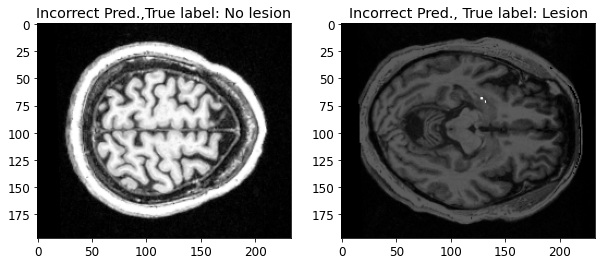

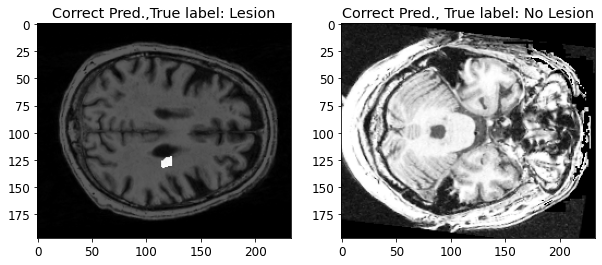

<Figure size 432x288 with 0 Axes>

In [38]:
matplotlib.rcParams['font.size']=12
fig=plt.figure(figsize=(10,10))
plt.subplot(221)
i=np.random.randint(0, len(p1_t0_xset))
plt.imshow(p1_t0_xset[i],cmap='Greys_r')
plt.title(f"Incorrect Pred.,True label: No lesion" )

plt.subplot(222)
j=np.random.randint(0, len(p0_t1_xset))
plt.title(f"Incorrect Pred., True label: Lesion" )
plt.imshow(p0_t1_xset[j],cmap='Greys_r')
plt.show()

fig=plt.figure(figsize=(10,10))
plt.subplot(223)
i=np.random.randint(0, len(p1_t1_xset))
plt.imshow(p1_t1_xset[i],cmap='Greys_r')
plt.title(f"Correct Pred.,True label: Lesion" )

plt.subplot(224)
j=np.random.randint(0, len(p0_t0_xset))
plt.title(f"Correct Pred., True label: No Lesion" )
plt.imshow(p0_t0_xset[j],cmap='Greys_r')
plt.show()
plt.tight_layout()

In [39]:
cm=confusion_matrix(y_test, y_pred_list)

In [40]:
type(cm)

numpy.ndarray

Confusion matrix, without normalization
[[2080   97]
 [ 262 1553]]


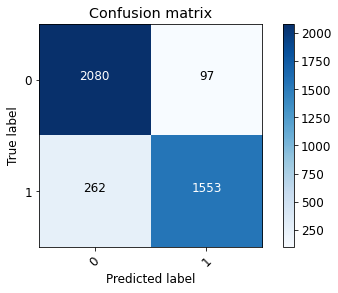

In [41]:
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cm,(0,1))

In [42]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      2177
         1.0       0.94      0.86      0.90      1815

    accuracy                           0.91      3992
   macro avg       0.91      0.91      0.91      3992
weighted avg       0.91      0.91      0.91      3992



In [ ]:
result1=classification_report(y_test, y_pred_list)
print(result1)

### Binary classification with CNN

In [ ]:
# Conv layer dimension calculator
h=197
w=233
p=1
k=3
s=1

h=(h-k+2*p)/s

In [ ]:
# Module has been put into Net- inheriting characteristics - like cat(animal) would pass animal characteristics to cat class 
# What attributes does Module already have ~\anaconda3\lib\site-packages\torch\nn\modules\module.py
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.cnn_layers=Sequential(
    
        # Defining a 2D Convolution layer o 196x232
        Conv2d(1,5,kernel_size=3,stride=1,padding=1),
        
        BatchNorm2d(5),
            
        ReLU(inplace=True),
#       input 196,232, output 97,115
        MaxPool2d(kernel_size=2, stride=2),
        
        # Defining another 2D convolution layer o 96,114
            
        Conv2d(5,5,kernel_size=3, stride=1, padding=1),
        
        BatchNorm2d(5),
        
        ReLU(inplace=True),
#          input 96,114   output 47,56
        MaxPool2d(kernel_size=2, stride=2)
        
        )
        
        self.linear_layers = Sequential(
            Linear(14210, 64),
            Linear(64,1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.linear_layers(x)
        return x

In [ ]:
x=torch.randn(1,1,197,233)
model=Net()
model(x)

In [ ]:
l_slice_num=all_lesion_slices.shape[0]
target1=np.ones(l_slice_num)

zero_slice_num=all_zero_slices.shape[0]//3 + 1
target2=np.zeros(zero_slice_num)

target=np.concatenate((target1,target2),axis=0)

train_x1=all_lesion_slices.reshape(l_slice_num,1,197,233)
train_x2=all_zero_slices[::3,:,:].reshape(zero_slice_num,1,197,233)

# turn to torch and concatenate


train_x1=torch.from_numpy(train_x1).float()

train_x2=torch.from_numpy(train_x2).float()
train_x=torch.cat([train_x1,train_x2],dim=0)

# means = train_x.mean(dim=1, keepdim=True)
# stds = train_x.std(dim=1, keepdim=True)
# normalized_data = (train_x - means) / stds
# train_x=normalized_data

train_y1=target.reshape(len(target))
train_y=torch.from_numpy(train_y1).float()

In [ ]:


train_x1=lesion_sections.reshape(220,1,197,233)
train_x2=lesion_sections2.reshape(220,1,197,233)

# turn to torch and concatenate


train_x1=torch.from_numpy(train_x1).float()

train_x2=torch.from_numpy(train_x2).float()
train_x=torch.cat([train_x1,train_x2],dim=0)


train_y1=target1.reshape(440)
train_y=torch.from_numpy(train_y1).float()


In [ ]:
target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=69)

In [ ]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
model = Net()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
cm2=confusion_matrix(y_test, y_pred_list)

In [ ]:
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cm2,(0,1))

In [ ]:
print(classification_report(y_test, y_pred_list))

### Segmentation with CNN

In [ ]:
from loss import enhanced_mixing_loss

#### *Access data:* 

In [ ]:
# All Slices

image_count=imageArray.shape[0]


all_lesion_slices=np.array([])
all_zero_slices=np.array([])

all_lesion_masks=np.array([])
all_zero_masks=np.array([])

zero_sum=0

for i in range(image_count):
    
    # 1. Get 3 tuples with coordinate for each dimension   
    lesion_index=np.array(maskArray[i,:,:,:].nonzero())
    
    # 2. Get index of slices with lesions along the top view
    top_index=np.unique(lesion_index[2])
    
    # 3. Get index of slices without lesions along top view
    top_lf_index=np.delete(np.arange(maskArray.shape[3]),top_index,axis=0)
    
    # 4. Create a scan with lesion and lesion free slices with the top view    
    zero_slices =imageArray[i,:-1,:-1,top_lf_index]    
    lesion_slices=imageArray[i,:-1,:-1,top_index]
    lesion_masks=maskArray[i,:-1,:-1,top_index]
    zero_masks=maskArray[i,:-1,:-1,top_lf_index]
    
    # 5. Create a zero mask sum for validation- all zero slice masks = 0 
    #zero_sum+=np.sum(maskArray[i,:,:,top_lf_index])
    
    # 6. All top view lesion and zero slices combined
    all_lesion_slices=np.concatenate((all_lesion_slices, lesion_slices), axis=0)\
    if all_lesion_slices.size else lesion_slices
    
    if i%3==0:
        all_zero_slices=np.concatenate((all_zero_slices, zero_slices), axis=0)\
        if all_zero_slices.size else zero_slices
    
    # 7. All lesion masks top view combined
    all_lesion_masks=np.concatenate((all_lesion_masks, lesion_masks), axis=0)\
    if all_lesion_masks.size else lesion_masks
    

     
    
  
    
    

In [ ]:
print("all_lesion_masks: ",all_lesion_masks.shape)
print("all_lesion_slices: ",all_lesion_slices.shape)
print("all_zero_slices: ",all_zero_slices.shape)

np.max(all_lesion_masks)

##### Setting up training and test sets

In [ ]:
l_slice_num=all_lesion_slices.shape[0]


zero_slice_num=all_zero_slices.shape[0]


train_x1=all_lesion_slices.reshape(l_slice_num,1,196,232)/254
train_x2=all_zero_slices.reshape(zero_slice_num,1,196,232)/254


train_y1=all_lesion_masks.reshape(l_slice_num,196,232)/254
train_y2=np.zeros(zero_slice_num*196*232).reshape(zero_slice_num,196,232)


# turn to torch and concatenate


train_x1=torch.from_numpy(train_x1).float()

train_x2=torch.from_numpy(train_x2).float()
train_x=torch.cat([train_x1,train_x2],dim=0)



train_y1=torch.from_numpy(train_y1).float()
train_y2=torch.from_numpy(train_y2).float()
train_y=torch.cat([train_y1,train_y2],dim=0)

# means = train_x.mean(dim=1, keepdim=True)
# stds = train_x.std(dim=1, keepdim=True)
# normalized_data = (train_x - means) / stds
# train_x=normalized_data



##### CNN

In [ ]:
# Module has been put into Net- inheriting characteristics - like cat(animal) would pass animal characteristics to cat class 
# What attributes does Module already have ~\anaconda3\lib\site-packages\torch\nn\modules\module.py
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.cnn_layers=Sequential(
    
        # Defining a 2D Convolution layer o 196x232
        Conv2d(1,5,kernel_size=3,stride=1,padding=1),
        
        BatchNorm2d(5),
            
        ReLU(inplace=True),
#       input 196,232, output 97,115
        MaxPool2d(kernel_size=2, stride=2),
        
        # Defining another 2D convolution layer o 96,114
            
        Conv2d(5,5,kernel_size=3, stride=1, padding=1),
        
        BatchNorm2d(5),
        
        ReLU(inplace=True),
            
#       input 96,114   output 47,56
        MaxPool2d(kernel_size=2, stride=2),
            
        nn.Upsample(scale_factor=2, mode='nearest'),
            
        Conv2d(5, 5, kernel_size=3, padding=1),
            
        ReLU(),
            
        nn.Upsample(scale_factor=2, mode='nearest'),
            
        Conv2d(5, 5, kernel_size=3, padding=0),
            
        ReLU(),

            
        nn.Conv2d(5, 1, kernel_size=1, padding=1),
        nn.Sigmoid()
        
        )        
    

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x) 
        #print(x.size())

        return x

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=69)

In [ ]:
x=torch.randn(1,1,197,233)
n=Net()
n(x)

In [ ]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 0.001

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(device)


In [ ]:
model = Net()
model.to(device)
print(model)
#criterion = enhanced_mixing_loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = enhanced_mixing_loss(y_batch,y_pred)
        #acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_acc += acc.item()
        
# | Acc: {epoch_acc/len(train_loader):.3f}
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} ')

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
cm2=confusion_matrix(y_test, y_pred_list)

In [ ]:
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cm2,(0,1))

In [ ]:
print(classification_report(y_test, y_pred_list))